In [1]:
import pandas as pd
import dask
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import re
import spacy
import seaborn as sns

import itertools

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark") \
    .getOrCreate()

sc = spark.sparkContext

In [90]:
#####change month
# df = spark.read.json("../data/gme_tweets_dec2.json")
df = spark.read.json("../data/gme_tweets_jan2.json")
# df = spark.read.json("../data/gme_tweets_feb2.json")
# df = spark.read.json("../data/gme_tweets_mar2.json")

df.show()

+--------------------+-------------------+--------------------+----------+---+--------------------+-------------------+--------+-----------+--------------------+--------------------+--------------------+----+--------------------+-----+---------+-------------+--------------------+-------+------------+----------+--------------+------+--------------------+--------+--------+----------+---------+---------+--------------------+--------------------+-------------------+-------+----------+---------------+-----+
|            cashtags|    conversation_id|          created_at|      date|geo|            hashtags|                 id|language|likes_count|                link|            mentions|                name|near|              photos|place|quote_url|replies_count|            reply_to|retweet|retweet_date|retweet_id|retweets_count|source|           thumbnail|    time|timezone|trans_dest|trans_src|translate|               tweet|                urls|            user_id|user_rt|user_rt_id|       

In [91]:
df.columns

['cashtags',
 'conversation_id',
 'created_at',
 'date',
 'geo',
 'hashtags',
 'id',
 'language',
 'likes_count',
 'link',
 'mentions',
 'name',
 'near',
 'photos',
 'place',
 'quote_url',
 'replies_count',
 'reply_to',
 'retweet',
 'retweet_date',
 'retweet_id',
 'retweets_count',
 'source',
 'thumbnail',
 'time',
 'timezone',
 'trans_dest',
 'trans_src',
 'translate',
 'tweet',
 'urls',
 'user_id',
 'user_rt',
 'user_rt_id',
 'username',
 'video']

In [92]:
from pyspark.sql.functions import avg, col

df.select('likes_count').agg(
    avg(col('likes_count'))
).show()

+------------------+
|  avg(likes_count)|
+------------------+
|13.862065116382906|
+------------------+



In [93]:
df.select('username','tweet','likes_count') \
    .orderBy(df['likes_count']\
    .desc()).toPandas().head(15)

,username,tweet,likes_count
0,ashwsbreal,robinhood decided this morning to suspend buyi...,760107
1,pathtomanliness,$GME $AMC https://t.co/jf7o0ndPNc,350354
2,mrbrowneyes2020,"Ok, since a lot of people seem confused, I'll ...",137299
3,webullglobal,"UPDATE: GME, AMC, and KOSS are no longer restr...",118576
4,moistcr1tikal,I have $0 in GME but I hope that shit hits 1k....,82615
5,dog_rates,This is Biscotti. He had a very good day. Exit...,78077
6,thehyyyype,robinhood decided this morning to suspend buyi...,70315
7,donaldjtrumpjr,"It took less than a day for big tech, big gove...",69133
8,endtwist,So many folks (esp. the media) are missing the...,67677
9,stoolpresidente,They want you to sell your $gme $nakd $nok and...,65630


In [94]:
df_tweets = df.select('username','tweet','likes_count').filter(df.language == "en").toPandas()

In [96]:
nlp = spacy.load('en_core_web_lg')

In [97]:
# list_of_sentences = [sentence for sentence in df_tweets.tweet]

# lines = []
# for sentence in list_of_sentences:
#     words = sentence.split()
#     for w in words:
#         lines.append(w)

lines = sc.parallelize(df_tweets.tweet)
lines = lines.map(lambda sentence: sentence.split()).collect()
lines = list(itertools.chain(*lines)) 

In [98]:
def remove_empty(x):
    if x != '':
        return x

In [99]:
# lines = [re.sub(r'[^A-Za-z0-9]+','',x) for x in lines]
# lines2 = []
# for word in lines:
#     if word != '':
#         lines2.append(word)

plines = sc.parallelize(lines)
lines2 = plines.map(lambda x: re.sub(r'[^A-Za-z0-9]+','',x)).filter(lambda x: remove_empty(x))

In [100]:
from nltk.stem.snowball import SnowballStemmer

s_stemmer = SnowballStemmer(language='english')

# stem = []
# for word in lines2:
#     stem.append(s_stemmer.stem(word))
    
stem = lines2.map(lambda x : s_stemmer.stem(x)).collect()

# Wasnt able to do next step through spark
stem2 = []
for word in stem:
    if word not in nlp.Defaults.stop_words:
        stem2.append(word)

In [107]:
df2 = pd.DataFrame(stem2)
df2 = df2[0].value_counts()

/home/steven/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


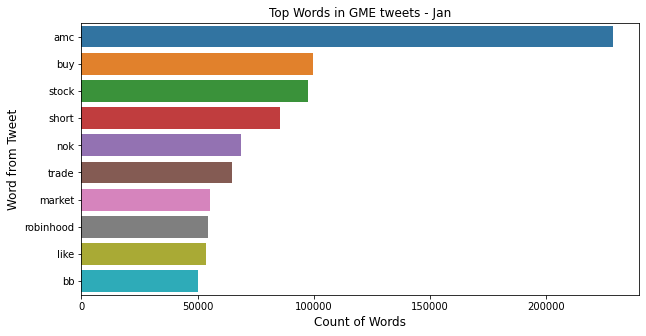

In [108]:
df2 = df2[1:11,] # do not include 'GME'
plt.figure(figsize=(10,5))
sns.barplot(df2.values,df2.index,alpha=1)
plt.title('Top Words in GME tweets - Jan') #Change month
plt.ylabel('Word from Tweet', fontsize=12)
plt.xlabel('Count of Words', fontsize=12)
plt.show()

In [24]:
df_dec = spark.read.json("../data/gme_tweets_dec2.json")
df_jan = spark.read.json("../data/gme_tweets_jan2.json")
df_feb = spark.read.json("../data/gme_tweets_feb2.json")
df_mar = spark.read.json("../data/gme_tweets_mar2.json")

In [27]:
tweet_counts_per_day = df_jan.groupBy('date').count().orderBy('date').toPandas().drop(0)
tweet_counts_per_day

,date,count
1,2021-01-01,216
2,2021-01-02,189
3,2021-01-03,217
4,2021-01-04,346
5,2021-01-05,369
6,2021-01-06,335
7,2021-01-07,295
8,2021-01-08,340
9,2021-01-09,218
10,2021-01-10,270


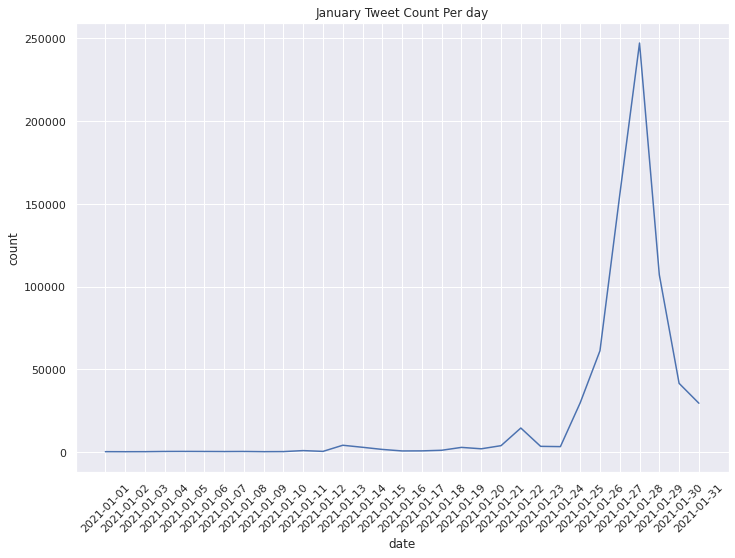

In [29]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(data=tweet_counts_per_day, x="date", y="count")
plt.title('January Tweet Count Per day')
plt.xticks(rotation=45)
None